In [1]:
from tifffile import imread, imwrite
import numpy as np
import copy
import h5py
import matplotlib
import io
import hdf5plugin as h5pl
import os
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from skimage import feature, draw
from PIL import Image, ImageChops
from skimage.transform import probabilistic_hough_line
import random

In [2]:
np.random.seed(1234)
random.seed(1234)

In [3]:
font = {
        'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 7
        }
padding = {
    'titlepad': 3,
    'labelpad': 1,
}
matplotlib.rc('font', **font)
matplotlib.rc('axes', **padding)

In [4]:
def get_random_patch_slices(dims, patch_size=[2, 128, 128]):
    
    rand_int = np.random.randint
    min_corner = tuple(rand_int(0, ms - ps + 1) if ms > ps else 0 for ms, ps in zip(dims, patch_size))

    return tuple(slice(mc, mc + ps) for mc, ps in zip(min_corner, patch_size))

In [5]:
def rand_patched_image(img, num_samples=5):
    dims = img.shape
    patches = [img[get_random_patch_slices(dims)] for _ in range(num_samples)]

    return np.concatenate(patches, axis=0)

In [6]:
def normalize(img):
    return img / np.amax(img)

In [7]:
def prerun_compression(raw_img, params):

    gamma = 0.9
    
    if raw_img.dtype == np.uint16:
        raw_size = np.prod(raw_img.shape) * 2
    elif raw_img.dtype == np.uint8:
        raw_size = np.prod(raw_img.shape)

    blocky_scores = []
    
    raw_scores = edge_scores(copy.deepcopy(raw_img), 'tmp/raw')
    blocky_scores.append(raw_scores)
    imwrite(f'tmp/raw.tif', raw_img)

    print(raw_scores)

    cs_ratios = []
    
    for i, param in enumerate(params):
        img = copy.deepcopy(raw_img)
        max_img = np.amax(raw_img)
        img = np.array(np.round(np.power(normalize(img), gamma) * 400), dtype=np.uint16)

        with io.BytesIO() as tmpfile:
            with h5py.File(tmpfile, 'w') as h5file:
                h5file.create_dataset('data', img.shape, np.uint16, data=img, chunks=(param[4], param[3], param[2]), **h5pl.FFMPEG(*param))
                cs_ratios.append(raw_size / tmpfile.getbuffer().nbytes)
            with h5py.File(tmpfile, 'r') as h5file:
                rec_array = np.array(h5file['data'])

        rec_array = np.array(np.round(np.power(normalize(rec_array), 1 / gamma) * max_img), dtype=np.uint16)
        blocky_scores.append(edge_scores(rec_array, f'tmp/grain{param[-2]}'))

        print('grain:', param[-2], cs_ratios[i], blocky_scores[i+1])

    return cs_ratios, blocky_scores

In [8]:
def edge_scores(img, fname):
    img = np.array(normalize(img) * 255, dtype=np.uint8)
    
    score = 0
    imwrite(f'{fname}.tif', img)
    shift_im = []
    line_im = []
    for i, im in enumerate(img):
        im = np.array(normalize(im) * 255, dtype=np.uint8)
        im = Image.fromarray(im)
        im = ImageChops.subtract(im, im.transform(im.size, Image.Transform.AFFINE, (1,0,1,0,1,1)))
        im = np.asarray(im)

        # im2 = ImageChops.subtract(im, im.transform(im.size, Image.Transform.AFFINE, (1,0,-1,0,1,-1)))
        # im2 = np.asarray(im2)
        # im = im1 + im2
        shift_im.append(im)

        im_zeros = np.zeros_like(im, np.uint8)
        # vertical and horizontal lines
        lines = probabilistic_hough_line(im, threshold=4, line_length=10, line_gap=0, theta=np.array([-np.pi/2, 0]))
        for line in lines:
            p0, p1 = line
            rr, cc = draw.line(p0[1], p0[0], p1[1], p1[0])
            im_zeros[rr, cc] = 1
            
        line_im.append(im_zeros)
        score += np.sum(im_zeros)
    
    shift_im = np.stack(shift_im, axis=0)
    
    line_im = np.stack(line_im, axis=0)
    line_im = line_im * 255

    imwrite(f'{fname}_shift.tif', shift_im)
    imwrite(f'{fname}_line.tif', line_im)

    return score / len(img)

In [9]:
def select_filmgrain(scores, grains, th=0.015):
    def fn(x, a, b, c):
        return a * np.exp(-b * x) + c
    def fit_fn(x, popt):
        return popt[0] * np.exp(-popt[1] * x) + popt[2]
    def derivative(x, popt):
        return -popt[0] * popt[1] * np.exp(-popt[1] * x)
    
    scores = np.array(scores)
    popt, _ = curve_fit(fn, grains, np.log(scores))

    idx = np.argwhere(np.abs(derivative(range(51), popt)) < th)
    if len(idx) > 0:
        idx = idx[0][0]
    else:
        idx = 15

    return idx

In [10]:
chunk = (128, 128, 2)

In [11]:
raw_img = imread('/data/duanb/NeuN/20210929_HDCF_R56-8_fibers_6-11_hiRes_NeuN_histMatched_medFilt.tif')

In [12]:
img_patches = rand_patched_image(raw_img)

In [13]:
params = []

grains = range(0, 51, 5)
for grain in grains:
    params.append((6, 6, *chunk, 1, 403, 400, 25, grain, 0))

In [14]:
cs_ratios, blocky_scores = prerun_compression(img_patches, params)

488.6
grain: 0 33.798865394533266 1217.3
grain: 5 34.00228286811248 1011.6
grain: 10 35.921946941460206 642.9
grain: 15 37.58229154719578 498.5
grain: 20 39.8443579766537 492.9
grain: 25 41.36329209795506 469.4
grain: 30 42.341387776198474 470.8
grain: 35 43.41857691798065 502.5
grain: 40 44.94924554183813 486.4
grain: 45 46.47284073181109 485.5
grain: 50 47.414267110403706 520.0


In [15]:
np.array(blocky_scores)

array([ 488.6, 1217.3, 1011.6,  642.9,  498.5,  492.9,  469.4,  470.8,
        502.5,  486.4,  485.5,  520. ])

In [16]:
select_filmgrain(blocky_scores[1:], grains)

/tmp/ipykernel_4074381/3298708634.py:3: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c


18

In [17]:
def fn(x, a, b, c):
    return a * np.exp(-b * x) + c
def fit_fn(x, popt):
    return popt[0] * np.exp(-popt[1] * x) + popt[2]
def derivative(x, popt):
    return -popt[0] * popt[1] * np.exp(-popt[1] * x)
def higher_derivative(x, popt):
    return popt[0] * popt[1] **2 * np.exp(-popt[1] * x)

In [18]:
popt, _ = curve_fit(fn, grains, np.log(blocky_scores[1:]))

/tmp/ipykernel_4074381/2830961852.py:2: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c


(0.0, 50.0)

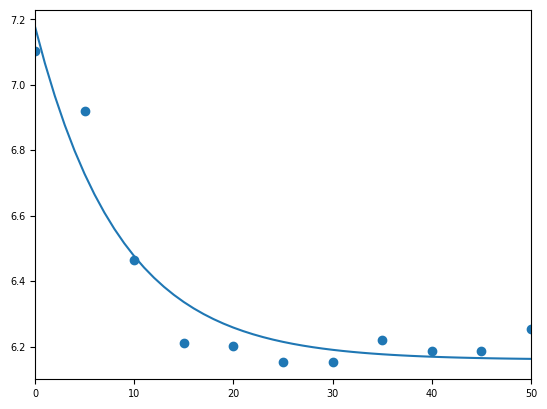

In [19]:
plt.scatter([g for g in grains], np.log(blocky_scores[1:]))
plt.plot(range(51), fit_fn(range(51), popt), label='fitting function')
# plt.plot(0.5, np.log(blocky_scores[0]), marker='^', color='r')
# plt.annotate("Raw", (1, np.log(blocky_scores[0])))
plt.xlim(0, 50)
# plt.hlines(np.log(blocky_scores[0]), 0, 50, linestyles='--', color='gray')

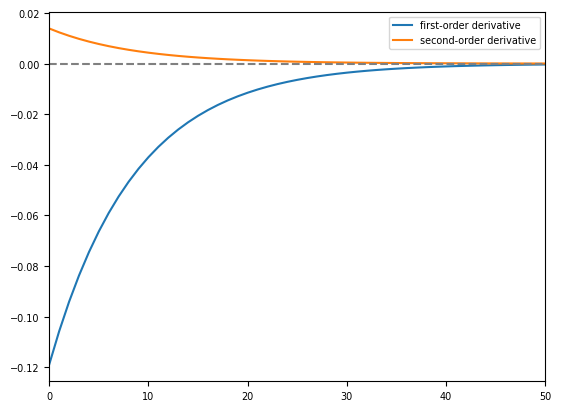

In [20]:
plt.plot(range(51), derivative(range(51), popt), label='first-order derivative')
plt.plot(range(51), higher_derivative(range(51), popt), label='second-order derivative')
plt.xlim(0, 50)
plt.legend()
plt.hlines(np.amax(derivative(range(51), popt)), 0, 50, linestyles='--', color='gray')

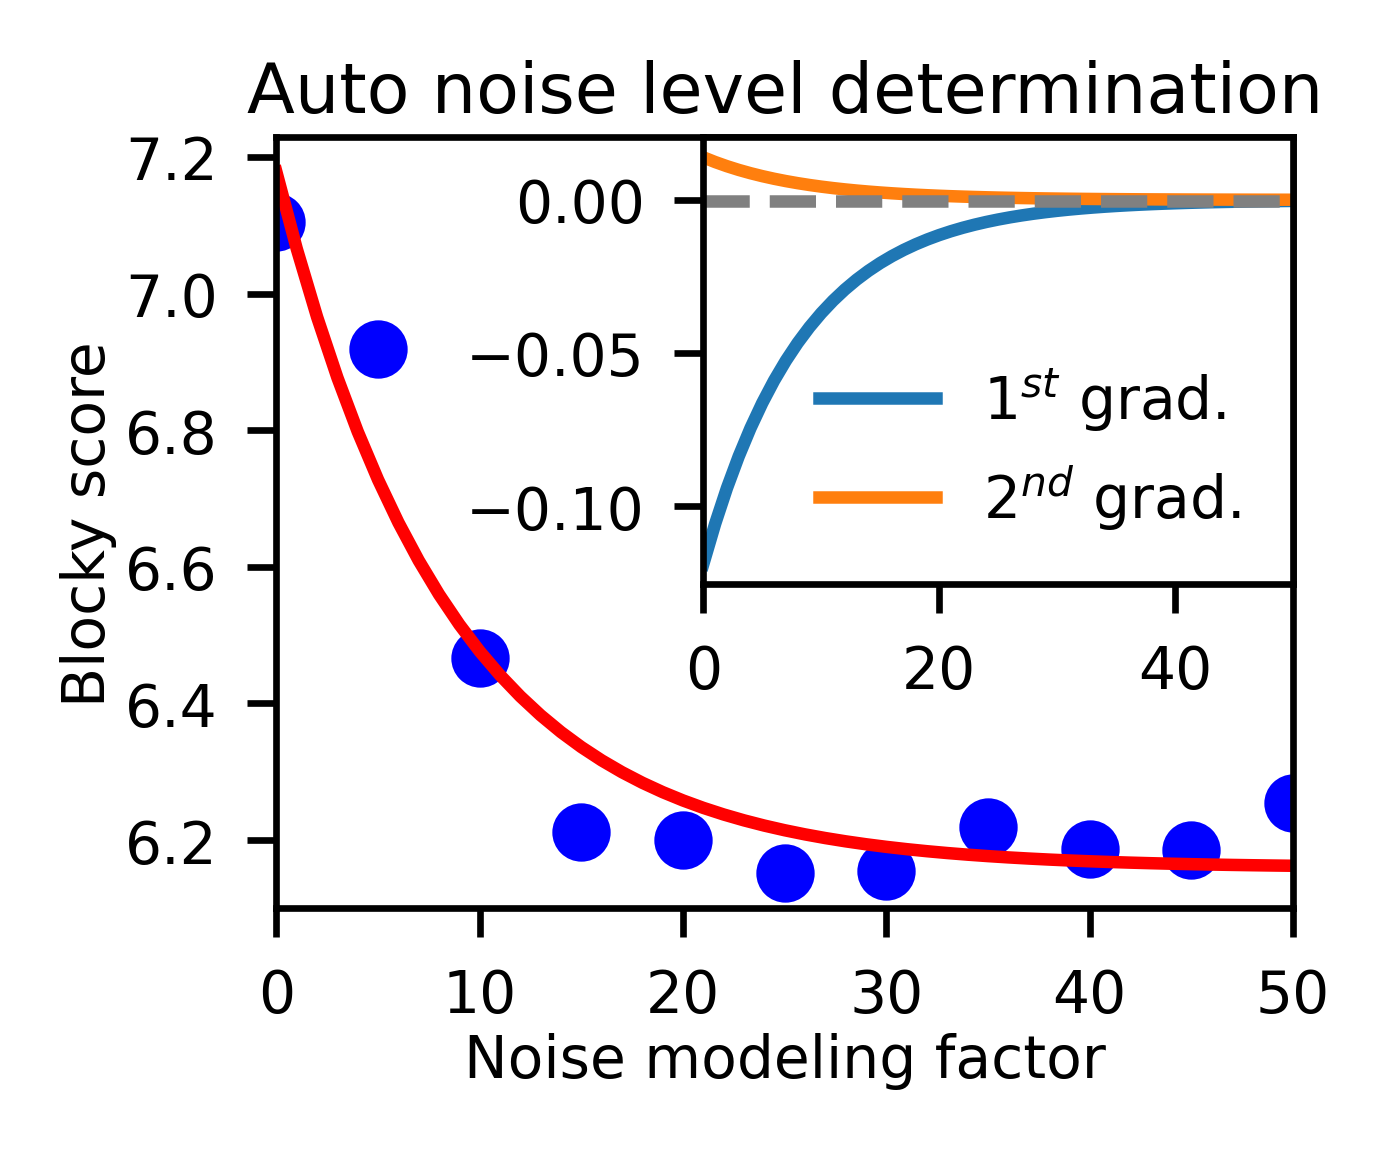

In [21]:
fig, ax = plt.subplots(figsize=(2.2, 1.8), dpi=600, ncols=1, nrows=1, layout='constrained')
ax.scatter([g for g in grains], np.log(blocky_scores[1:]), color='b')
ax.plot(range(51), fit_fn(range(51), popt), color='r')
ax.set_xlim(0, 50)
ax.set_xticks(range(0, 51, 10))
ax.set_xlabel('Noise modeling factor')
ax.set_ylabel('Blocky score')
ax.set_title('Auto noise level determination')

# inset axes....
axins = ax.inset_axes([0.42, 0.42, 0.58, 0.58])
axins.plot(range(51), derivative(range(51), popt), label='$1^{st}$ grad.')
axins.plot(range(51), higher_derivative(range(51), popt), label='$2^{nd}$ grad.')
axins.set_xlim(0, 50)
axins.legend(frameon=False)
axins.hlines(np.amax(derivative(range(51), popt)), 0, 50, linestyles='--', color='gray')
# axins.set_xticklabels('')
plt.savefig('noise_modeling.pdf', bbox_inches='tight')